In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from datasets import load_dataset
import os
import ipywidgets as widgets
from IPython.display import display, HTML

from src.utils.viz.attention import get_attention_maps, display_instances
from src.utils.analysis.hooked_vit import HookedViT
import timm

In [2]:
def load_partmae():
    return timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        pretrained_cfg_overlay={
            "file": "../../artifacts/model-2knf0d16:v0/backbone.ckpt"
        },
        pretrained_strict=False,
    ).cuda().eval()

In [3]:
# Load model and dataset
base_model = load_partmae()
model = HookedViT(base_model)
dataset = load_dataset("frgfm/imagenette", split="validation", name="160px")

# Define image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

INFO:timm.models._builder:Loading pretrained weights from file (../../artifacts/model-2knf0d16:v0/backbone.ckpt)
INFO:timm.models._helpers:Loaded  from checkpoint '../../artifacts/model-2knf0d16:v0/backbone.ckpt'
INFO:timm.models._builder:Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [4]:
def process_and_display(img_idx, threshold=0.9):
    # Load and transform image
    img = dataset[img_idx]["image"]
    img_tensor = transform(img).unsqueeze(0)
    
    # Get attention maps
    attentions, threshold_attn = get_attention_maps(
        model, 
        img_tensor.cuda(), 
        discard_ratio=threshold
    )
    
    # Convert PIL image to numpy array
    img_array = np.array(img.resize((224, 224)))
    
    # Plot original image and attention masks
    n_heads = attentions.shape[0]
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    fig.suptitle(f'Attention Visualization (Sample {img_idx})', fontsize=16)
    
    # Clear all axes first
    for row in axes:
        for ax in row:
            ax.axis('off')
    
    # Original image in larger size - use only one axis for the central image
    central_ax = axes[0, 1]  # Use single central axis
    central_ax.imshow(img_array)
    central_ax.set_title('Original Image')
    
    # Show attention patterns
    for head in range(n_heads):
        if threshold is not None:
            mask_img = display_instances(
                img_array.copy(), 
                threshold_attn[head],
                fname=f"head_{head}_attention.png",
                blur=True
            )
            axes[row, col].imshow(mask_img)
        else:
            axes[row, col].imshow(attentions[head], cmap='viridis')
            
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Head {head}')
    
    plt.tight_layout()
    plt.show()

NameError: name 'col' is not defined

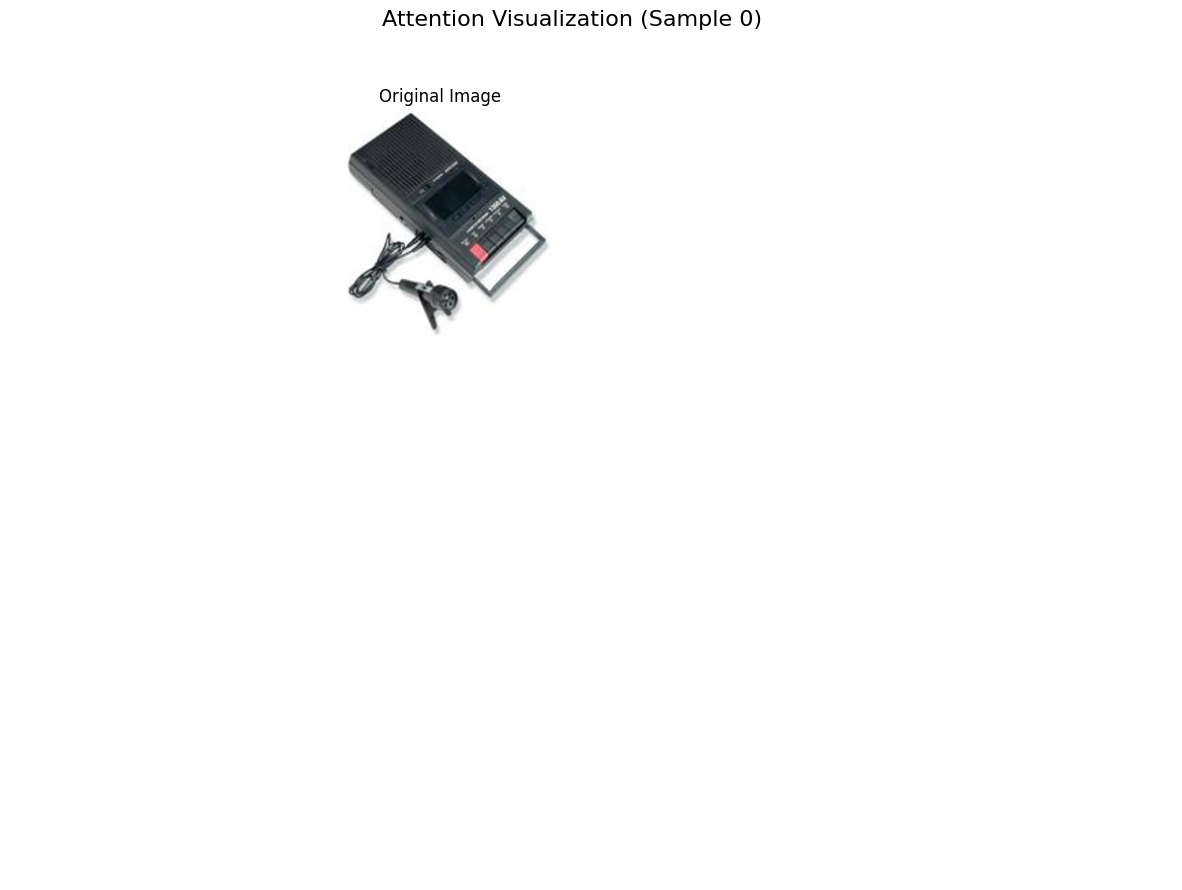

In [5]:
# Create widgets for interactive visualization
image_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(dataset)-1,
    step=1,
    description='Image Index:'
)

threshold_slider = widgets.FloatSlider(
    value=0.9,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Threshold:'
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        process_and_display(image_slider.value, threshold_slider.value)

image_slider.observe(on_change, names='value')
threshold_slider.observe(on_change, names='value')

# Display widgets and initial visualization
display(widgets.VBox([image_slider, threshold_slider]))
process_and_display(0, 0.9)